In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import struct
import socket

from pcap.pcap_util import PcapReader

class Reader:
    def __init__(self, fn, limit=None):
        self.pcap = PcapReader(fn)
        self.limit = limit
        self.n_read = 0
    def close(self):
        self.pcap.close()
    def __iter__(self):
        return self
    def __next__(self):
        try:
            if self.limit and self.n_read == self.limit:
                raise StopIteration

            pkt = next(self.pcap)
        except:
            self.close()
            raise

#        pkt.time = pkt.time - 1547730000
        self.n_read += 1
        return pkt

def read_pcaps(limit=None):
    a_reader = Reader('data/pcap/a.tcp.nano.pcap', limit=limit)
    b_reader = Reader('data/pcap/b.tcp.nano.cut.pcap', limit=limit)
    return a_reader, b_reader

TCP_FLAGS = {"F":0x1, "S":0x2, "R":0x4, "P":0x8,
			  "A":0x10, "U":0x20, "E":0x40, "C":0x80,
			  0x1:"F", 0x2:"S", 0x4:"R", 0x8:"P",
			  0x10:"A", 0x20:"U", 0x40:"E", 0x80:"C"}

syn_flags = TCP_FLAGS['S']
synack_flags = TCP_FLAGS['S'] | TCP_FLAGS['A']
ack_flags = TCP_FLAGS['A']

is_syn = lambda p: p['TCP'].flags == syn_flags
is_synack = lambda p: p['TCP'].flags == synack_flags
is_ack = lambda p: p['TCP'].flags == ack_flags

session_id = lambda p: ((p['IP'].src, p['TCP'].sport), (p['IP'].dst, p['TCP'].dport))

In [59]:
def handshake_times(a, b):
    sessions = {}

    for pkt in a:
        if 'IP' not in pkt or 'TCP' not in pkt:
            continue

        tcp = pkt['TCP']

        if is_syn(pkt):
            s = ((pkt['IP'].src, pkt['TCP'].sport), (pkt['IP'].dst, pkt['TCP'].dport), pkt['TCP'].seq)

            if s not in sessions:
                sessions[s] = [(float(pkt.time), tcp.seq, tcp.ack), None, None]

        elif is_ack(pkt):
            s = ((pkt['IP'].src, pkt['TCP'].sport), (pkt['IP'].dst, pkt['TCP'].dport), pkt['TCP'].seq - 1)
            if s in sessions:
                if sessions[s][2] is not None:
#                    print('wtf')
                    del sessions[s]
                    continue
                sessions[s][2] = (float(pkt.time), tcp.seq, tcp.ack)

    for pkt in b:
        if 'IP' not in pkt or 'TCP' not in pkt or not is_synack(pkt):
            continue

        tcp = pkt['TCP']

        s = ((pkt['IP'].dst, pkt['TCP'].dport), (pkt['IP'].src, pkt['TCP'].sport), pkt['TCP'].ack - 1)
        if s in sessions:
            if sessions[s][1] is not None:
#                print('wtf2')
                del sessions[s]
                continue
            sessions[s][1] = (float(pkt.time), tcp.seq, tcp.ack)

    for s, times in sessions.items():
        if times[1] is not None and times[2] is not None:
#            print(times[0][1], times[0][2], times[1][1], times[1][2], times[2][1], times[2][2])
            times = [t[0] for t in times]
            if not (times[0] < times[1] < times[2]):
#                print('wtf3')
                continue
            yield s, times[0], times[1], times[2]


In [62]:
spny, nysp = read_pcaps()
dfs_ab = pd.DataFrame(handshake_times(spny, nysp), columns=['session', 'syn', 'synack', 'ack'])

In [63]:
spny, nysp = read_pcaps()
dfs_ba = pd.DataFrame(handshake_times(nysp, spny), columns=['session', 'syn', 'synack', 'ack'])

In [64]:
for df in [dfs_ab, dfs_ba]:
    df['diff_1'] = (df.synack - df.syn).astype(float)
    df['diff_2'] = (df.ack - df.synack).astype(float)

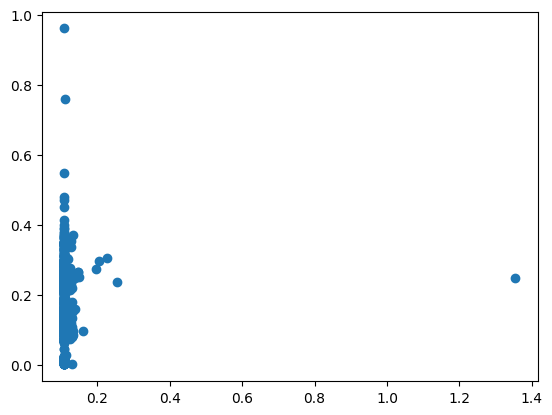

In [65]:
plt.scatter(dfs_ab.diff_1, dfs_ab.diff_2)
#plt.hist(dfs_ab.diff_2, bins=300, color='b')
plt.show()

In [45]:
dfs_ab.describe()

,syn,synack,ack,diff_1,diff_2
count,9.400000e+01,9.400000e+01,9.400000e+01,94.000000,94.000000
mean,1.547730e+09,1.547730e+09,1.547730e+09,0.109796,0.133617
std,1.102842e-01,1.102259e-01,9.573914e-02,0.004668,0.083619
min,1.547730e+09,1.547730e+09,1.547730e+09,0.108901,0.000164
25%,1.547730e+09,1.547730e+09,1.547730e+09,0.108914,0.087844
50%,1.547730e+09,1.547730e+09,1.547730e+09,0.108957,0.113451
75%,1.547730e+09,1.547730e+09,1.547730e+09,0.108971,0.204262
max,1.547730e+09,1.547730e+09,1.547730e+09,0.146881,0.327840


100
count    704.000000
mean     108.946880
std        0.030798
min      108.897209
25%      108.913124
50%      108.954906
75%      108.965874
max      109.075308
Name: diff_1, dtype: float64
count    550.000000
mean     108.930236
std        0.028624
min      108.895302
25%      108.909845
50%      108.917117
75%      108.951092
max      109.067202
Name: diff_2, dtype: float64


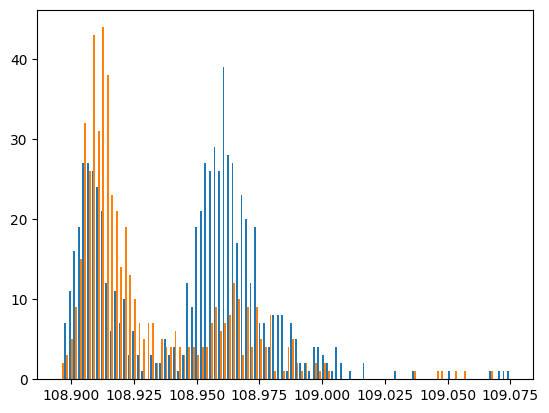

In [80]:
mn = 108.85
mx = 109.1
bins = 100#round((mx - mn) * 1000)
print(bins)
x1 = dfs_ab.diff_1 * 1000
x1 = x1[x1 > mn]
x1 = x1[x1 < mx]
x2 = dfs_ba.diff_2 * 1000
x2 = x2[x2 > mn]
x2 = x2[x2 < mx]
print(x1.describe())
print(x2.describe())

plt.hist([x1, x2], bins=bins, label=['sp-ny', 'ny-sp'])
plt.show()

In [7]:


for df in [dfs_ab, dfs_ba]:
#    plt.hist(df.where(df['diff'] < 0.3).where(df['diff'] > -0.5)['diff']*1000, bins=300)
    plt.hist(df.where(df.diff_3 < 0.3).where(df.diff_3 > -0.3).diff_3, bins=30)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'diff_3'